# Introduction to Survival Analysis with ML4H

_Survival analysis_ is a core modeling paradigm of clinical ML that data scientists from other domains are unlikely to be familiar with. In survival analysis, the aim is to predict when an event might occur, such as a heart attack, stroke, or the onset of heart feailure. Survival analysis can also require incorporating other time-dependent phenomenon, such as patients dropping out of a study, or the random times at which patients see a provider and generate new data.  

In this notebook, we will use the classic MNIST dataset to develop a toy model of survival analysis using ML4H. First, we will train a classifier on MNIST using ML4H abstractions. Next, we will use the digit label to determine the threshold for randomly generating synthetic events. Finally, we will incorporate a random lag to model the process of our "patients" seeing their physicians in a health system.  

In [1]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from ml4h.defines import StorageType
from ml4h.arguments import parse_args
from ml4h.TensorMap import TensorMap, Interpretation
from ml4h.tensor_generators import test_train_valid_tensor_generators
from ml4h.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4h.recipes import test_multimodal_multitask, train_multimodal_multitask, saliency_maps

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# Paths
HD5_FOLDER = './mnist_hd5s/'
OUTPUT_FOLDER = './runs/'

In [3]:
def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

In [4]:
def plot_mnist(sides):
    train, _, _ = load_data('mnist.pkl.gz')
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    sides = int(np.ceil(np.sqrt(min(sides, mnist_images.shape[0]))))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i in range(sides*sides):
        axes[i // sides, i % sides].imshow(mnist_images[i, ..., 0], cmap='gray')
        axes[i // sides, i % sides].set_xticks(())
        axes[i // sides, i % sides].set_yticks(())

loading data...
(50000, 784)


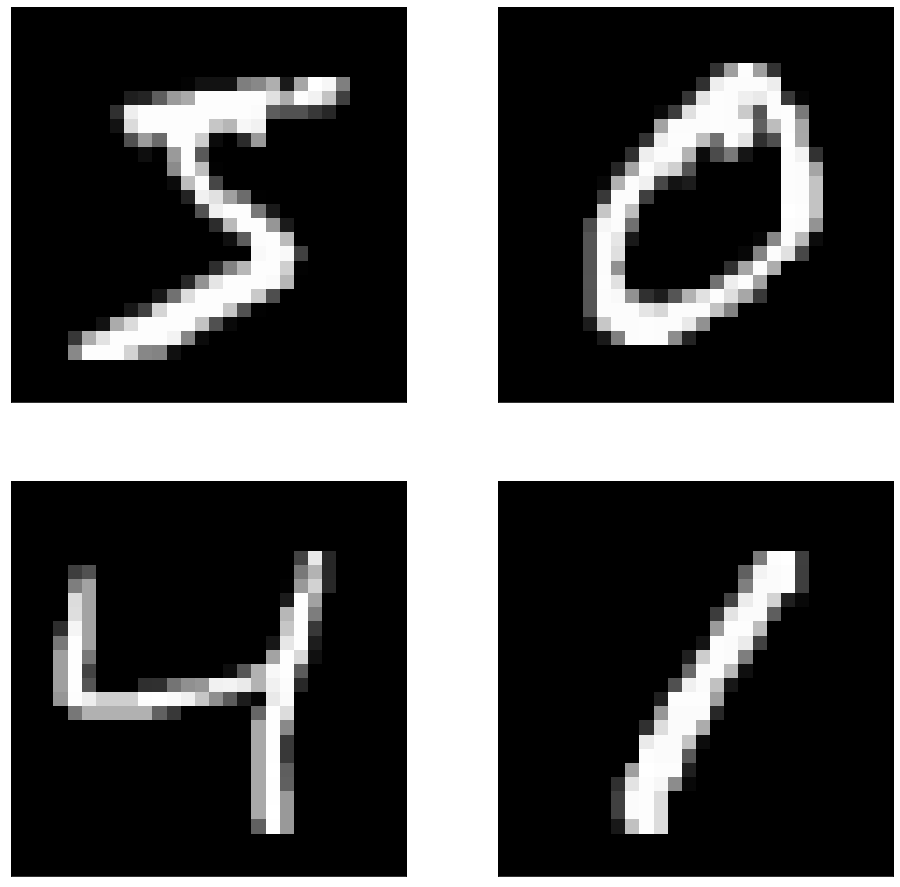

In [5]:
plot_mnist(4)

loading data...
(50000, 784)


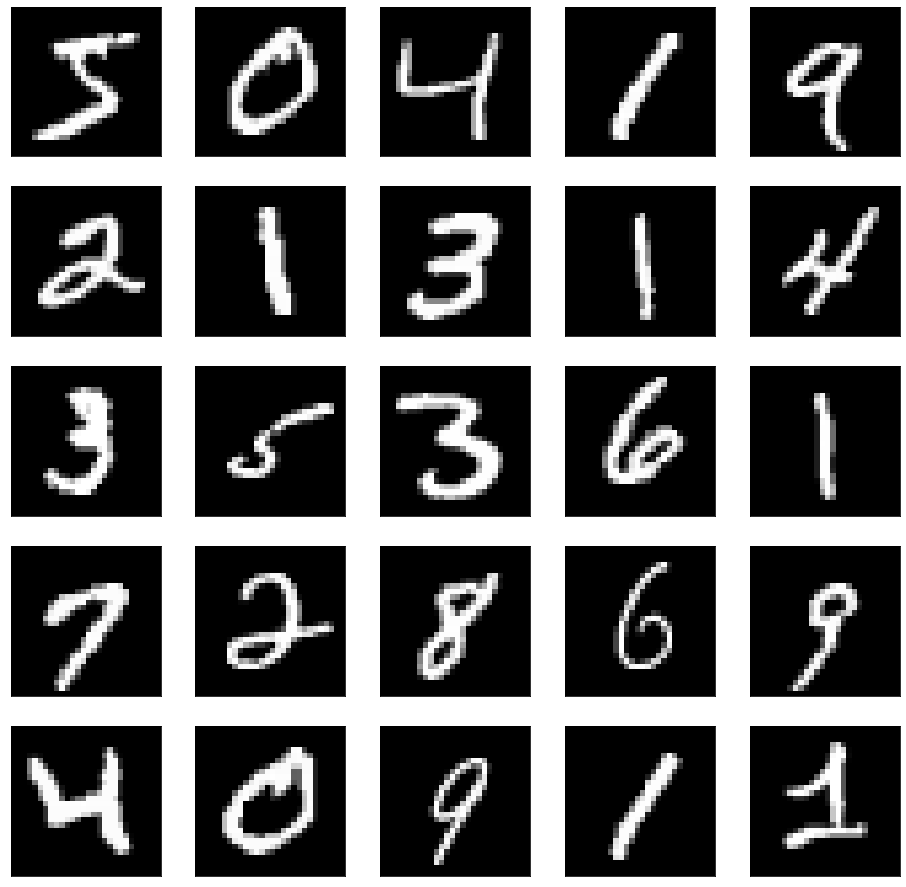

In [6]:
plot_mnist(25)

## Tensorization
It is often helpful to separate data preparation from model training.  In ml4h we call the final data preparation process tensorization.  Tensorization involves gathering all input files (XMLS, CSVs, DICOMs, PNGs, etc) and consolidating them into compressed HD5 files.  We tend to make one HD5 file per individual in the cohort we are studying.  The files contain the raw data and labels (inputs and outputs) we will use to train models.

In [ ]:
def mnist_as_hd5(hd5_folder):
    train, _, _ = load_data('mnist.pkl.gz')
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)
    for i, mnist_image in enumerate(mnist_images):
        with h5py.File(os.path.join(hd5_folder, f'{i}.hd5'), 'w') as hd5:
            hd5.create_dataset('mnist_image', data=mnist_image)
            hd5.create_dataset('mnist_label', data=[train[1][i]])
        if (i+1) % 5000 == 0:
            print(f'Wrote {i+1} MNIST images and labels as HD5 files')

In [ ]:
mnist_as_hd5(HD5_FOLDER)

## TensorMaps
The central data structure in the ml4h codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to construct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.  The most important method of each TensorMap is their ***tensor_from_file*** function.  This callback function takes the TensorMap, an HD5 file handle, and an optional dictionary as input arguments and it returns a numpy array.

In [ ]:
def mnist_image_from_hd5(tm, hd5, dependents={}):
     return np.array(hd5['mnist_image'])

def mnist_label_from_hd5(tm, hd5, dependents={}):
    one_hot = np.zeros(tm.shape, dtype=np.float32)
    one_hot[int(hd5['mnist_label'][0])] = 1.0
    return one_hot

## Command Line Friendly Jupyter Notebooks
By directly setting the `sys.argv` array in our jupyter notebooks we make the process of translating from notebook to command line straightforward.  For example, the cell below can be replicated on the command line by running:
```
./scripts/tf.sh $HOME/ml/ml4h/recipes.py --mode train --tensors ./mnist_hd5s/ \
    --input_tensors mnist_image --output_tensors mnist_label \
    --batch_size 64 --test_steps 64 --epochs 24 \
    --output_folder ./runs/ --id learn_mnist
```
The script `tf.sh` starts the appropriate docker container and then calls python on the provided arguments.


In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist.mnist_image',
            '--output_tensors', 'mnist.mnist_label',
            '--batch_size', '64',
            '--test_steps', '64',
            '--epochs', '24',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'learn_mnist'
           ]
args = parse_args()
train_multimodal_multitask(args)

## Evaluating ML Models in ml4h
Each ml4h training run creates several plots to give insight into model performance and learning dynamics.  The plots created will depend on the TensorMaps used but in general will include a metric history showing learning curves of each metric tracked during training, performance plots like ROC and Precision Recall curves for classifiers or scatter plots for regressors, calibration plots, and a t-SNE plot showing a 2D representation of the learned embedding of the trained model.

## Survival Analysis
In addition to categorical classification tasks shown above, the ML4Health code base supports survival analysis.  In survival analysis, we consider the relative time before an outcome was observed, and we allow for samples to leave our study at anytime, before having an event.  Survival analysis is implemented via the TensorMap interpretations TIME_TO_EVENT and SURVIVAL_CURVE. 

The TIME_TO_EVENT interpretation is the most straight forward.  TIME_TO_EVENT TensorMaps *tensor_from_file* function returns an array with two values.  The first value indicates whether or not an event occurred for this sample.  The second value indicates the total days of follow up from when the sample enrolled in the study until either an event ocurred or they left the study.   

In [8]:
# Defined in ml4h/tensormap/mnist.py 
def mnist_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    tensor[0] = 1.0 if np.random.rand() > (label / 10) else 0.0
    tensor[1] = np.random.randint(1, 3650)
    return tensor


In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist.mnist_image',
            '--output_tensors', 'mnist.mnist_time_to_event',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '30',
            '--batch_size', '32',
            '--epochs', '1',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_time_to_event'
           ]
args = parse_args()
train_multimodal_multitask(args)

## Model the Entire Survival Curve
SURVIVAL_CURVE TensorMaps model the survival curve with quantized steps.  These TensorMaps **tensor_from_file** functions return an array of 1s and 0s. The first half of the array contains 1s for each time step that the sample survived and 0s elsewhere. The second half of the array contains a 1 at the time step at which an event occurred if there was one, otherwise it contains only zeros.  Here we use the MNIST dataset to create a synthetic survival analysis cohort.  We use the MNIST label to determine the likelihood of having events and we model several different shapes of survival curve and distributions of follow up.  The **days_window** and **shape** fields of these TensorMaps controls how quantized the predicted survival curves will be.  Specifically each time bin will cover **days_window** / (**shape[-1]**/2) days. **shape** should be an even number because half the array is used for indicating survival up until an event or censorship and the other half indicates events.

In [ ]:
# Defined in ml4h/tensormap/mnist.py
def _mnist_label_as_survival_curve(tm, hd5, dependents={}):
    label = float(hd5['mnist_label'][0])
    has_disease = 1.0 if np.random.rand() > (label / 10) else 0.0
    days_follow_up = np.random.randint(1, 3650)
        
    intervals = int(tm.shape[0] / 2)
    days_per_interval = tm.days_window / intervals
    survival_then_censor = np.zeros(tm.shape, dtype=np.float32)
    for i, day_delta in enumerate(np.arange(0, tm.days_window, days_per_interval)):
        survival_then_censor[i] = float(day_delta < days_follow_up)
        if day_delta <= days_follow_up < day_delta + days_per_interval:
            survival_then_censor[intervals+i] = has_disease
    return survival_then_censor
    

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist.mnist_image',
            '--output_tensors', 'mnist.mnist_survival_curve',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '16',
            '--learning_rate', '0.02',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_label_as_survival_curve'
           ]
args = parse_args()
train_multimodal_multitask(args)